In [1]:
using AutoRisk
using AutoViz
using PGFPlots
using Colors

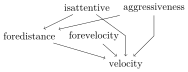

In [2]:
d = JLD.load("../../data/bayesnets/base_test.jld") 
base_bn = d["bn"]
var_edges = d["var_edges"]

d = JLD.load("../../data/bayesnets/prop_test.jld") 
prop_bn = d["bn"]

In [3]:
# build the generator
sampler = UniformAssignmentSampler(var_edges)
dynamics = Dict(:velocity=>:forevelocity)
num_veh_per_lane = 20
min_p = get_passive_behavior_params(err_p_a_to_i = .01)
max_p = get_aggressive_behavior_params(err_p_a_to_i = .01)
behgen = CorrelatedBehaviorGenerator(min_p, max_p)
gen = BayesNetLaneGenerator(base_bn, prop_bn, sampler, dynamics, num_veh_per_lane, behgen);

In [4]:
num_lanes = 3
roadway = gen_straight_roadway(num_lanes)
scene = Scene(num_veh_per_lane * num_lanes)
models = Dict{Int,DriverModel}()
rand!(gen, roadway, scene, models, 2);

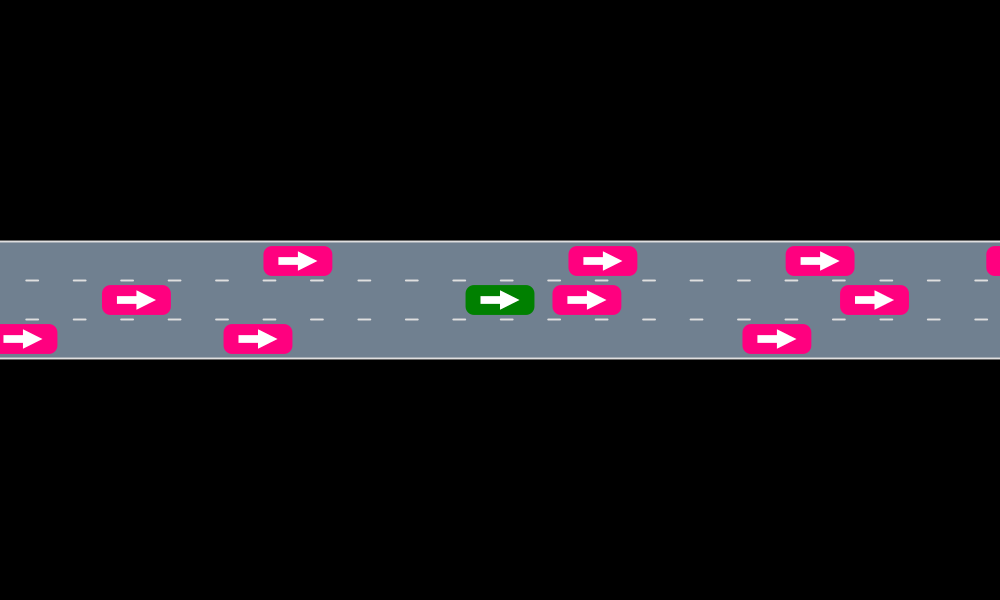

In [5]:
carcolors = Dict{Int,Colorant}()
carcolors[39] = colorant"green"
render(scene, roadway, cam=CarFollowCamera{Int}(39, 13.), car_colors=carcolors)

In [6]:
# scene feature extractors
function get_static_features(scene::Scene, roadway::Roadway)
    # feature containers, censors
    timegaps = zeros(Float64, length(scene))
    timegap_censor_hi = 10.
    ttcs = zeros(Float64, length(scene))
    ttc_censor_hi = 30.
    velocities = zeros(Float64, length(scene))
    distance_fores = zeros(Float64, length(scene))
    distance_fore_censor_hi = 100.
    
    for veh_idx in 1:length(scene)
        ego_veh = scene.entities[veh_idx]
        velocities[veh_idx] = ego_veh.state.v
        
        neigh = get_neighbor_fore_along_lane(scene, veh_idx, roadway)
        
        # if the fore vehicle does not exist then set as censor high
        if neigh.ind == 0
            timegaps[veh_idx] = timegap_censor_hi
            distance_fores[veh_idx] = distance_fore_censor_hi
            ttcs[veh_idx] = ttc_censor_hi
        else
            # get both vehicles 
            rear_veh = scene.entities[veh_idx]
            fore_veh = scene.entities[neigh.ind]
            
            # want the time for the rear vehicle's front to reach the fore vehicle's back
            v = rear_veh.state.v
            
            # first term is distance between centers
            # second moves from fore vehicle center to back bumper
            # third moves from rear vehicle center to front bumper
            Δs = (fore_veh.state.posF.s - rear_veh.state.posF.s) - (fore_veh.def.length / 2) - (rear_veh.def.length / 2)
            timegaps[veh_idx] = min(Δs / v, timegap_censor_hi)
            
            # distance fore
            distance_fores[veh_idx] = min(Δs, distance_fore_censor_hi)
            
            # time to collision
            Δv = fore_veh.state.v - rear_veh.state.v
            if Δv < 0.
                ttcs[veh_idx] = min(max(-1 * Δs / Δv, 0.), ttc_censor_hi)
            else # this means fore vehicle moving away too quickly
                ttcs[veh_idx] = ttc_censor_hi
            end
            
        end
    end
    return timegaps, ttcs, velocities, distance_fores
end

get_static_features (generic function with 1 method)

In [7]:
num_scenes, num_veh = 1000, num_veh_per_lane
emergent = Dict{String, Array{Float64}}()
emergent["timegap"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["ttc"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["velocity"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["distance_fore"] = zeros(Float64, num_scenes * num_veh * num_lanes)
for scene_idx in 1:num_scenes
    rand!(gen, roadway, scene, models, scene_idx)
    timegaps, ttcs, velocities, distance_fores = get_static_features(scene, roadway)
    s = (scene_idx - 1) * num_lanes * num_veh
    e = s + num_lanes * num_veh
    println(s)
    println(e)
    emergent["timegap"][s+1:e] = timegaps
    emergent["ttc"][s+1:e] = ttcs
    emergent["velocity"][s+1:e] = velocities
    emergent["distance_fore"][s+1:e] = distance_fores
end

0
60
60
120
120
180
180
240
240
300
300
360
360
420
420
480
480
540
540
600
600
660
660
720
720
780
780
840
840
900
900
960
960
1020
1020
1080
1080
1140
1140
1200
1200
1260
1260
1320
1320
1380
1380
1440
1440
1500
1500
1560
1560
1620
1620
1680
1680
1740
1740
1800
1800
1860
1860
1920
1920
1980
1980
2040
2040
2100
2100
2160
2160
2220
2220
2280
2280
2340
2340
2400
2400
2460
2460
2520
2520
2580
2580
2640
2640
2700
2700
2760
2760
2820
2820
2880
2880
2940
2940
3000
3000
3060
3060
3120
3120
3180
3180
3240
3240
3300
3300
3360
3360
3420
3420
3480
3480
3540
3540
3600
3600
3660
3660
3720
3720
3780
3780
3840
3840
3900
3900
3960
3960
4020
4020
4080
4080
4140
4140
4200
4200
4260
4260
4320
4320
4380
4380
4440
4440
4500
4500
4560
4560
4620
4620
4680
4680
4740
4740
4800
4800
4860
4860
4920
4920
4980
4980
5040
5040
5100
5100
5160
5160
5220
5220
5280
5280
5340
5340
5400
5400
5460
5460
5520
5520
5580
5580
5640
5640
5700
5700
5760
5760
5820
5820
5880
5880
5940
5940
6000
6000
6060
6060
6120
6120
6180
6180
62

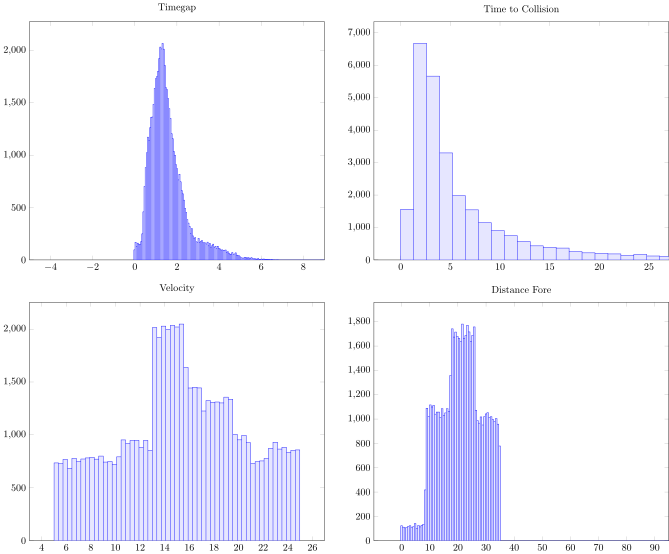

In [8]:
# analyze emergent behavior
g = GroupPlot(2, 2, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
nbins = 100
timegap_axis = Axis(Plots.Histogram(emergent["timegap"], bins=nbins), 
                    ymin=0, 
                    xmax=9, 
                    xmin=-5,
                    width="12cm",
                    height="10cm",
                    title="Timegap")
push!(g, timegap_axis)
ttc_axis = Axis(Plots.Histogram(emergent["ttc"], bins=nbins), 
                    ymin=0, 
                    xmax=27,
                    width="12cm",
                    height="10cm",
                    title="Time to Collision")
push!(g, ttc_axis)
velocity_axis = Axis(Plots.Histogram(emergent["velocity"], bins=nbins), 
                    ymin=0,  
                    width="12cm",
                    height="10cm",
                    title="Velocity")
push!(g, velocity_axis)
distance_fore_axis = Axis(Plots.Histogram(emergent["distance_fore"], bins=nbins), 
                    ymin=0,  
                    xmax=95,
                    width="12cm",
                    height="10cm",
                    title="Distance Fore")
push!(g, distance_fore_axis)
g